## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

## Data Loading

In [2]:
df = fetch_california_housing(as_frame=True).frame

## Data Inspection

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [5]:
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

## Outlier Detection and Handling

#### Detect Outliers Using IQR Method

In [7]:
# Detect outliers using IQR method
def detect_outliers_iqr(data, column_name):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"{column_name}: {len(outliers)} outliers detected ({len(outliers)/len(data)*100:.2f}%)")
    print(f"  Lower bound: {lower_bound:.4f}")
    print(f"  Upper bound: {upper_bound:.4f}")
    return lower_bound, upper_bound, outliers

# Check outliers in all features
print("=== OUTLIER DETECTION ===\n")
for column in df.columns:
    detect_outliers_iqr(df[column], column)
    print()

=== OUTLIER DETECTION ===

MedInc: 681 outliers detected (3.30%)
  Lower bound: -0.7064
  Upper bound: 8.0130

HouseAge: 0 outliers detected (0.00%)
  Lower bound: -10.5000
  Upper bound: 65.5000

AveRooms: 511 outliers detected (2.48%)
  Lower bound: 2.0232
  Upper bound: 8.4699

AveBedrms: 1424 outliers detected (6.90%)
  Lower bound: 0.8659
  Upper bound: 1.2397

Population: 1196 outliers detected (5.79%)
  Lower bound: -620.0000
  Upper bound: 3132.0000

AveOccup: 711 outliers detected (3.44%)
  Lower bound: 1.1510
  Upper bound: 4.5610

Latitude: 0 outliers detected (0.00%)
  Lower bound: 28.2600
  Upper bound: 43.3800

Longitude: 0 outliers detected (0.00%)
  Lower bound: -127.4850
  Upper bound: -112.3250

MedHouseVal: 1071 outliers detected (5.19%)
  Lower bound: -0.9809
  Upper bound: 4.8241



#### Visualize Outliers with Boxplots

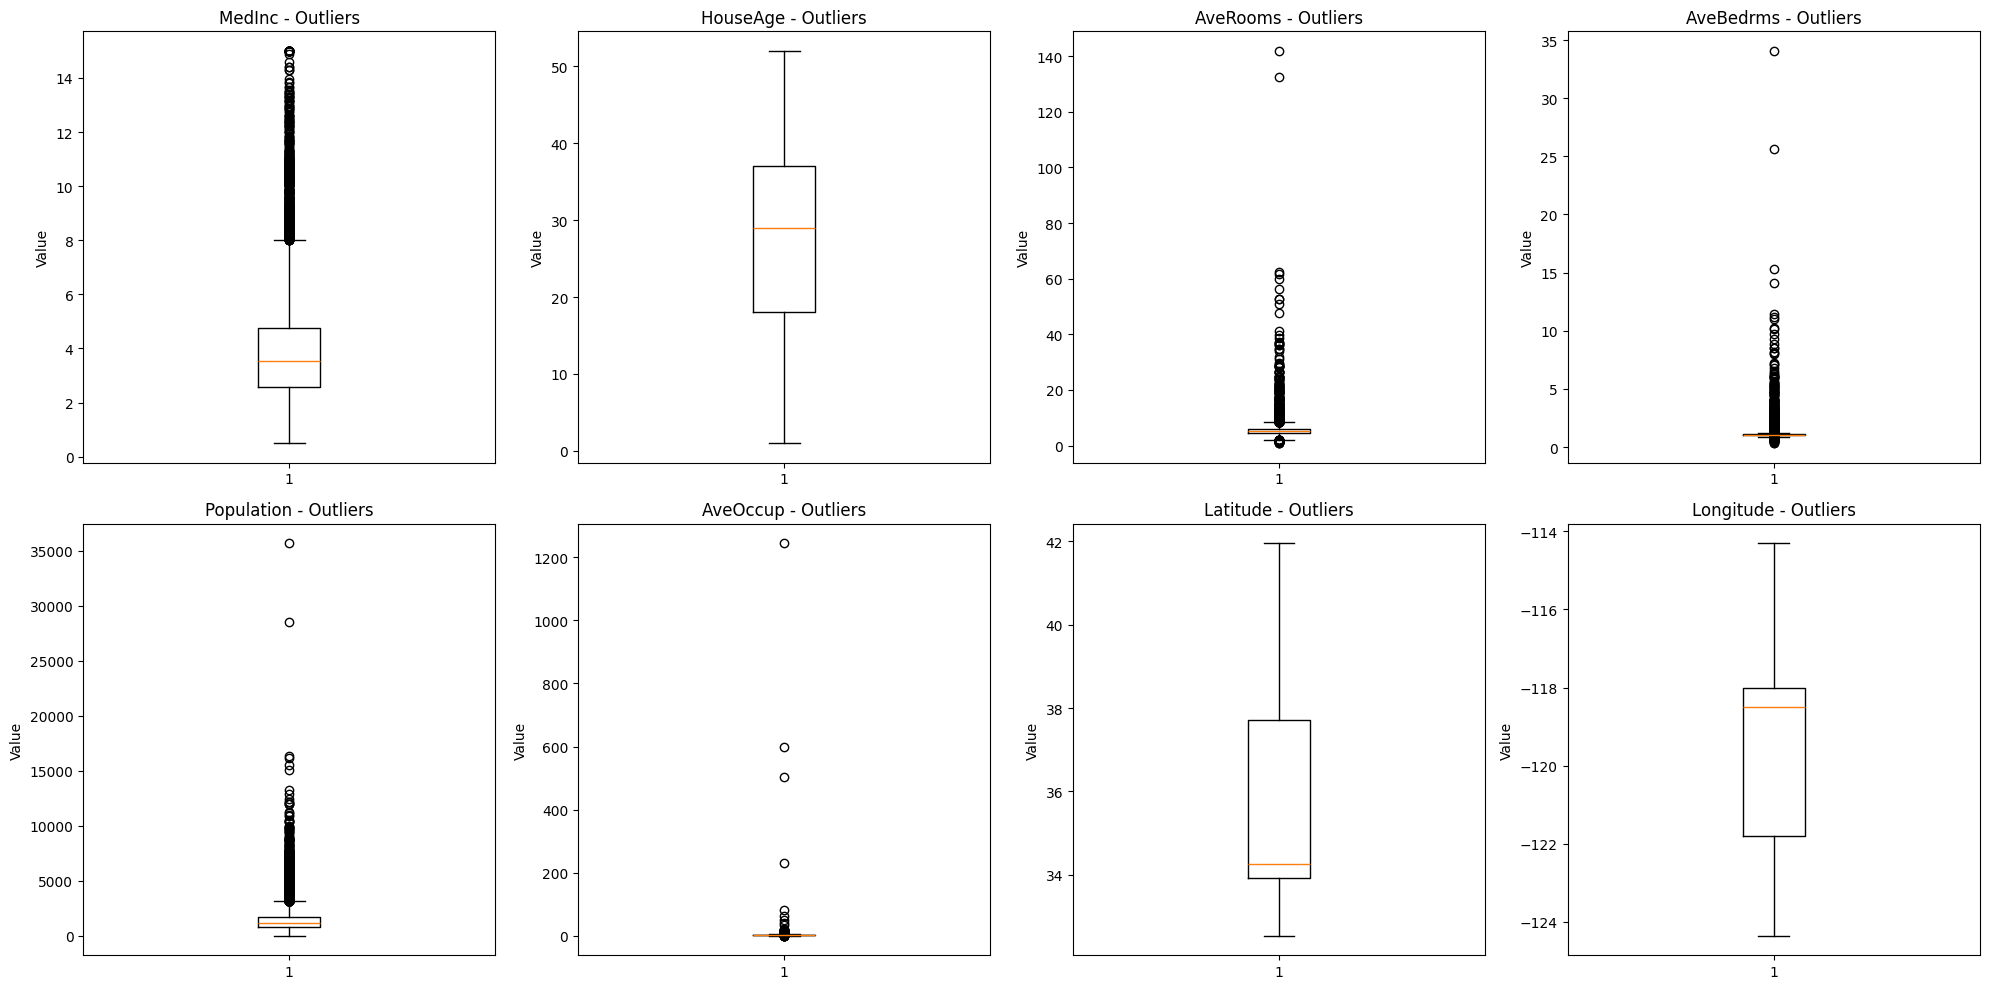

In [8]:
# Visualize outliers using boxplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, column in enumerate(df.columns):
    if i < len(axes):
        axes[i].boxplot(df[column])
        axes[i].set_title(f'{column} - Outliers')
        axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

#### Remove Outliers

In [9]:
# Remove outliers using IQR method
def remove_outliers_iqr(df, columns_to_clean):
    df_clean = df.copy()
    removed_count = 0
    
    for column in columns_to_clean:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers before removal
        outliers_before = len(df_clean[(df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)])
        
        # Remove outliers
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
        
        print(f"{column}: Removed {outliers_before} outliers")
    
    total_removed = len(df) - len(df_clean)
    print(f"\nTotal samples removed: {total_removed} ({total_removed/len(df)*100:.2f}%)")
    print(f"Remaining samples: {len(df_clean)} ({len(df_clean)/len(df)*100:.2f}%)")
    
    return df_clean

# Clean the dataset by removing outliers from all columns
print("=== REMOVING OUTLIERS ===\n")
df_clean = remove_outliers_iqr(df, df.columns)

=== REMOVING OUTLIERS ===

MedInc: Removed 681 outliers
HouseAge: Removed 0 outliers
AveRooms: Removed 439 outliers
AveBedrms: Removed 1116 outliers
Population: Removed 1063 outliers
AveOccup: Removed 528 outliers
Latitude: Removed 0 outliers
Longitude: Removed 0 outliers
MedHouseVal: Removed 581 outliers

Total samples removed: 4408 (21.36%)
Remaining samples: 16232 (78.64%)


#### Compare Before and After Cleaning

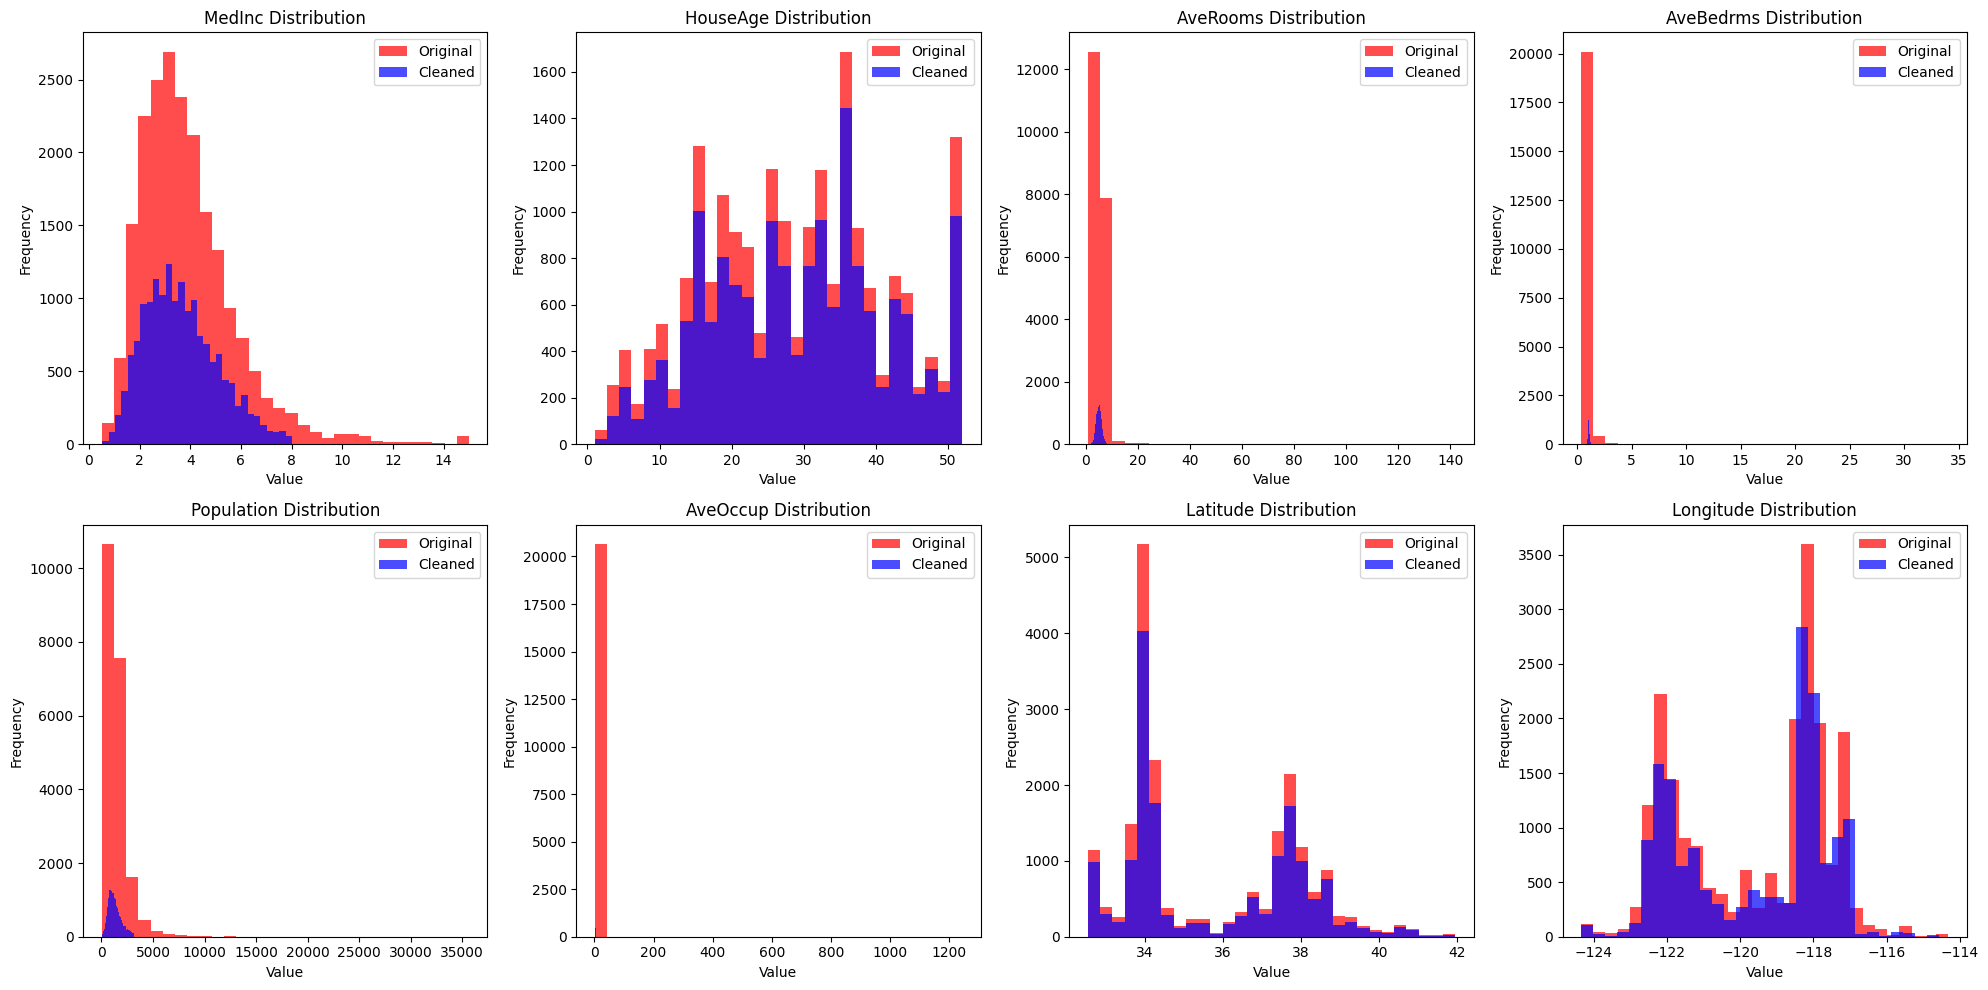

Original dataset shape: (20640, 9)
Cleaned dataset shape: (16232, 9)


In [10]:
# Compare distributions before and after outlier removal
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, column in enumerate(df.columns):
    if i < len(axes):
        axes[i].hist(df[column], alpha=0.7, label='Original', bins=30, color='red')
        axes[i].hist(df_clean[column], alpha=0.7, label='Cleaned', bins=30, color='blue')
        axes[i].set_title(f'{column} Distribution')
        axes[i].legend()
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")

## Data Preparation

In [11]:
# Use cleaned dataset for regression
X = df_clean.drop(columns=['MedHouseVal']).values
y = df_clean['MedHouseVal'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target range: {y.min():.2f} to {y.max():.2f}")

# Split data for regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\nAfter split:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Features shape: (16232, 8)
Target shape: (16232,)
Target range: 0.15 to 4.68

After split:
X_train shape: (12985, 8)
X_test shape: (3247, 8)
y_train shape: (12985,)
y_test shape: (3247,)


## Reshape Data

In [12]:
# For neural networks, we can use the features directly or reshape
# Let's keep it simple - use features as-is for Dense layers
print(f"Input features: {X_train.shape[1]}")
print(f"Using direct feature input for neural networks")

# For compatibility with existing code structure
X_train_nn = X_train
X_test_nn = X_test

print(f"Neural network input shape: {X_train_nn.shape}")

Input features: 8
Using direct feature input for neural networks
Neural network input shape: (12985, 8)


## Helper Functions

In [13]:
def _train_val_slice(X, y, val_split=0.1):
    n = X.shape[0]
    n_val = int(np.floor(n * val_split))
    if n_val <= 0:
        raise ValueError("val_split too small for given data size")
    return X[:-n_val], y[:-n_val], X[-n_val:], y[-n_val:]

def calculate_regression_metrics(model, X_train_like, y_train, val_split=0.1):
    """Calculate R2, MSE, MAE for both training and validation sets"""
    X_tr, y_tr, X_val, y_val = _train_val_slice(X_train_like, y_train, val_split)
    
    # Get predictions
    p_tr = model.predict(X_tr, verbose=0).flatten()
    p_val = model.predict(X_val, verbose=0).flatten()
    
    # Calculate metrics
    return {
        'train_r2': float(r2_score(y_tr, p_tr)),
        'train_mse': float(mean_squared_error(y_tr, p_tr)),
        'train_mae': float(mean_absolute_error(y_tr, p_tr)),
        'val_r2': float(r2_score(y_val, p_val)),
        'val_mse': float(mean_squared_error(y_val, p_val)),
        'val_mae': float(mean_absolute_error(y_val, p_val))
    }

## ReLU Network

#### Adam: Model Definition

In [14]:
relu_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Adam: Compile

In [15]:
relu_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#### Adam: Train

In [16]:
start = time.time()
history_relu = relu_model.fit(X_train_nn, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=2)
adam_relu_time = time.time() - start

Epoch 1/20
366/366 - 3s - 9ms/step - loss: 0.4006 - mae: 0.4531 - val_loss: 0.2429 - val_mae: 0.3681
Epoch 2/20
366/366 - 2s - 5ms/step - loss: 0.2699 - mae: 0.3789 - val_loss: 0.2297 - val_mae: 0.3488
Epoch 3/20
366/366 - 2s - 5ms/step - loss: 0.2545 - mae: 0.3652 - val_loss: 0.2448 - val_mae: 0.3732
Epoch 4/20
366/366 - 2s - 6ms/step - loss: 0.2423 - mae: 0.3556 - val_loss: 0.2283 - val_mae: 0.3509
Epoch 5/20
366/366 - 2s - 5ms/step - loss: 0.2341 - mae: 0.3452 - val_loss: 0.2489 - val_mae: 0.3847
Epoch 6/20
366/366 - 2s - 5ms/step - loss: 0.2292 - mae: 0.3419 - val_loss: 0.2094 - val_mae: 0.3249
Epoch 7/20
366/366 - 2s - 5ms/step - loss: 0.2199 - mae: 0.3341 - val_loss: 0.2044 - val_mae: 0.3378
Epoch 8/20
366/366 - 2s - 6ms/step - loss: 0.2120 - mae: 0.3254 - val_loss: 0.1886 - val_mae: 0.3088
Epoch 9/20
366/366 - 2s - 6ms/step - loss: 0.2072 - mae: 0.3224 - val_loss: 0.1972 - val_mae: 0.3284
Epoch 10/20
366/366 - 2s - 6ms/step - loss: 0.2058 - mae: 0.3208 - val_loss: 0.1954 - val_m

#### Adam: Metrics

In [17]:
relu_adam_metrics = calculate_regression_metrics(relu_model, X_train_nn, y_train, val_split=0.1)
print("ReLU Adam Regression Metrics:")
for metric, value in relu_adam_metrics.items():
    print(f"  {metric}: {value:.4f}")

ReLU Adam Regression Metrics:
  train_r2: 0.8105
  train_mse: 0.1650
  train_mae: 0.2834
  val_r2: 0.7920
  val_mse: 0.1831
  val_mae: 0.3063


#### Adam: Evaluate

In [18]:
relu_eval = relu_model.evaluate(X_test_nn, y_test, verbose=0)
y_pred_relu = relu_model.predict(X_test_nn, verbose=0).flatten()

print(f"ReLU Adam Test Results:")
print(f"  Test Loss (MSE): {relu_eval[0]:.4f}")
print(f"  Test MAE: {relu_eval[1]:.4f}")
print(f"  Test R²: {r2_score(y_test, y_pred_relu):.4f}")

ReLU Adam Test Results:
  Test Loss (MSE): 0.2011
  Test MAE: 0.3136
  Test R²: 0.7598


#### SGD: Model Definition

In [19]:
sgd_relu = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### SGD: Compile

In [20]:
sgd_relu.compile(optimizer='sgd', loss='mse', metrics=['mae'])

#### SGD: Training

In [21]:
start = time.time()
history_relu_sgd = sgd_relu.fit(X_train_nn, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=2)
sgd_relu_time = time.time() - start

Epoch 1/20
366/366 - 2s - 6ms/step - loss: 0.3976 - mae: 0.4656 - val_loss: 0.2871 - val_mae: 0.4161
Epoch 2/20
366/366 - 1s - 4ms/step - loss: 0.2724 - mae: 0.3837 - val_loss: 0.2565 - val_mae: 0.3625
Epoch 3/20
366/366 - 2s - 5ms/step - loss: 0.2567 - mae: 0.3692 - val_loss: 0.2245 - val_mae: 0.3508
Epoch 4/20
366/366 - 1s - 4ms/step - loss: 0.2478 - mae: 0.3614 - val_loss: 0.2260 - val_mae: 0.3464
Epoch 5/20
366/366 - 1s - 3ms/step - loss: 0.2398 - mae: 0.3551 - val_loss: 0.2255 - val_mae: 0.3410
Epoch 6/20
366/366 - 1s - 4ms/step - loss: 0.2338 - mae: 0.3492 - val_loss: 0.2468 - val_mae: 0.3793
Epoch 7/20
366/366 - 1s - 4ms/step - loss: 0.2308 - mae: 0.3469 - val_loss: 0.2146 - val_mae: 0.3398
Epoch 8/20
366/366 - 1s - 4ms/step - loss: 0.2248 - mae: 0.3404 - val_loss: 0.2083 - val_mae: 0.3290
Epoch 9/20
366/366 - 1s - 3ms/step - loss: 0.2203 - mae: 0.3375 - val_loss: 0.2161 - val_mae: 0.3307
Epoch 10/20
366/366 - 2s - 4ms/step - loss: 0.2190 - mae: 0.3368 - val_loss: 0.2581 - val_m

#### SGD: Metrics

In [22]:
relu_sgd_metrics = calculate_regression_metrics(sgd_relu, X_train_nn, y_train, val_split=0.1)
print("ReLU SGD Regression Metrics:")
for metric, value in relu_sgd_metrics.items():
    print(f"  {metric}: {value:.4f}")

ReLU SGD Regression Metrics:
  train_r2: 0.7925
  train_mse: 0.1807
  train_mae: 0.2988
  val_r2: 0.7901
  val_mse: 0.1848
  val_mae: 0.3080


#### SGD: Evaluate

In [23]:
relu_sgd_eval = sgd_relu.evaluate(X_test_nn, y_test, verbose=0)
y_pred_relu_sgd = sgd_relu.predict(X_test_nn, verbose=0).flatten()

print(f"ReLU SGD Test Results:")
print(f"  Test Loss (MSE): {relu_sgd_eval[0]:.4f}")
print(f"  Test MAE: {relu_sgd_eval[1]:.4f}")
print(f"  Test R²: {r2_score(y_test, y_pred_relu_sgd):.4f}")

ReLU SGD Test Results:
  Test Loss (MSE): 0.2129
  Test MAE: 0.3275
  Test R²: 0.7458


#### Adam: Loss Plot

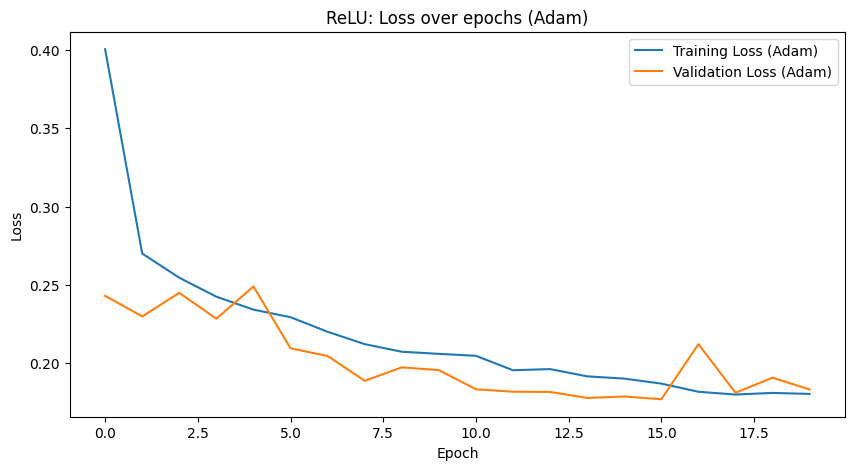

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(history_relu.history['loss'], label='Training Loss (Adam)')
plt.plot(history_relu.history['val_loss'], label='Validation Loss (Adam)')
plt.title('ReLU: Loss over epochs (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### SGD: Loss Plot

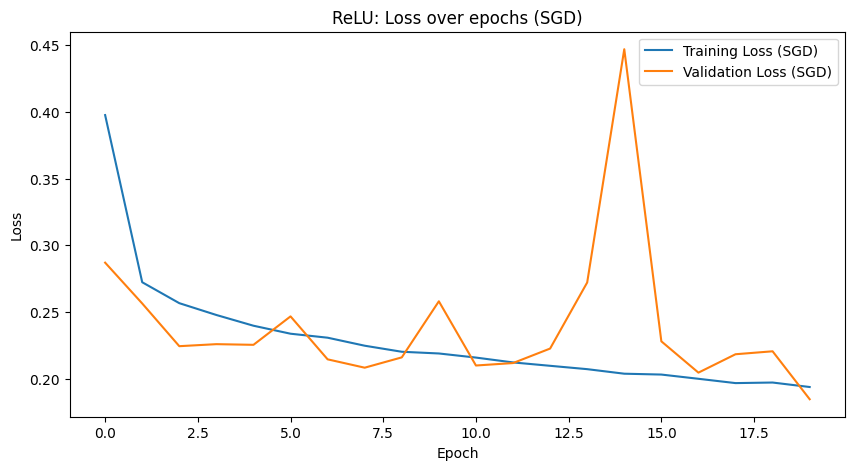

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(history_relu_sgd.history['loss'], label='Training Loss (SGD)')
plt.plot(history_relu_sgd.history['val_loss'], label='Validation Loss (SGD)')
plt.title('ReLU: Loss over epochs (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Tanh Network

In [26]:
tanh_model = Sequential([
    Dense(512, activation='tanh', input_shape=(X_train_nn.shape[1],)),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1, activation='linear')
])

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Adam: Compile

In [27]:
tanh_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#### Adam: Train

In [28]:
start = time.time()
history_tanh = tanh_model.fit(X_train_nn, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=2)
adam_tanh_time = time.time() - start

Epoch 1/20
366/366 - 4s - 10ms/step - loss: 0.4438 - mae: 0.4749 - val_loss: 0.2383 - val_mae: 0.3596
Epoch 2/20
366/366 - 2s - 6ms/step - loss: 0.2671 - mae: 0.3767 - val_loss: 0.2170 - val_mae: 0.3388
Epoch 3/20
366/366 - 2s - 6ms/step - loss: 0.2481 - mae: 0.3607 - val_loss: 0.2399 - val_mae: 0.3609
Epoch 4/20
366/366 - 2s - 6ms/step - loss: 0.2431 - mae: 0.3528 - val_loss: 0.2116 - val_mae: 0.3391
Epoch 5/20
366/366 - 2s - 6ms/step - loss: 0.2376 - mae: 0.3491 - val_loss: 0.2055 - val_mae: 0.3335
Epoch 6/20
366/366 - 2s - 6ms/step - loss: 0.2223 - mae: 0.3350 - val_loss: 0.2108 - val_mae: 0.3262
Epoch 7/20
366/366 - 2s - 6ms/step - loss: 0.2227 - mae: 0.3354 - val_loss: 0.2072 - val_mae: 0.3288
Epoch 8/20
366/366 - 2s - 5ms/step - loss: 0.2149 - mae: 0.3292 - val_loss: 0.2126 - val_mae: 0.3342
Epoch 9/20
366/366 - 2s - 5ms/step - loss: 0.2138 - mae: 0.3284 - val_loss: 0.2212 - val_mae: 0.3426
Epoch 10/20
366/366 - 2s - 5ms/step - loss: 0.2067 - mae: 0.3226 - val_loss: 0.2002 - val_

#### Adam: Metrics

In [29]:
tanh_adam_metrics = calculate_regression_metrics(tanh_model, X_train_nn, y_train, val_split=0.1)
print("Tanh Adam Regression Metrics:")
for metric, value in tanh_adam_metrics.items():
    print(f"  {metric}: {value:.4f}")

Tanh Adam Regression Metrics:
  train_r2: 0.8139
  train_mse: 0.1620
  train_mae: 0.2803
  val_r2: 0.7847
  val_mse: 0.1896
  val_mae: 0.3056


#### Adam: Evaluate

In [30]:
tanh_adam_eval = tanh_model.evaluate(X_test_nn, y_test, verbose=0)
y_pred_tanh = tanh_model.predict(X_test_nn, verbose=0).flatten()

print(f"Tanh Adam Test Results:")
print(f"  Test Loss (MSE): {tanh_adam_eval[0]:.4f}")
print(f"  Test MAE: {tanh_adam_eval[1]:.4f}")
print(f"  Test R²: {r2_score(y_test, y_pred_tanh):.4f}")

Tanh Adam Test Results:
  Test Loss (MSE): 0.2071
  Test MAE: 0.3120
  Test R²: 0.7526


#### SGD: Model Definition

In [31]:
sgd_tanh = Sequential([
    Dense(512, activation='tanh', input_shape=(X_train_nn.shape[1],)),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(32, activation='tanh'),
    Dense(1, activation='linear')
])

c:\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### SGD: Compile

In [32]:
sgd_tanh.compile(optimizer='sgd', loss='mse', metrics=['mae'])

#### SGD: Training

In [33]:
start = time.time()
history_tanh_sgd = sgd_tanh.fit(X_train_nn, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=2)
sgd_tanh_time = time.time() - start

Epoch 1/20
366/366 - 1s - 4ms/step - loss: 0.3787 - mae: 0.4650 - val_loss: 0.3362 - val_mae: 0.4598
Epoch 2/20
366/366 - 1s - 3ms/step - loss: 0.3053 - mae: 0.4137 - val_loss: 0.2872 - val_mae: 0.4093
Epoch 3/20
366/366 - 2s - 5ms/step - loss: 0.2807 - mae: 0.3910 - val_loss: 0.2933 - val_mae: 0.3854
Epoch 4/20
366/366 - 1s - 4ms/step - loss: 0.2701 - mae: 0.3820 - val_loss: 0.2414 - val_mae: 0.3632
Epoch 5/20
366/366 - 2s - 4ms/step - loss: 0.2632 - mae: 0.3765 - val_loss: 0.2566 - val_mae: 0.3655
Epoch 6/20
366/366 - 1s - 4ms/step - loss: 0.2582 - mae: 0.3701 - val_loss: 0.2479 - val_mae: 0.3627
Epoch 7/20
366/366 - 2s - 5ms/step - loss: 0.2536 - mae: 0.3667 - val_loss: 0.2513 - val_mae: 0.3803
Epoch 8/20
366/366 - 2s - 4ms/step - loss: 0.2496 - mae: 0.3628 - val_loss: 0.2246 - val_mae: 0.3493
Epoch 9/20
366/366 - 2s - 6ms/step - loss: 0.2428 - mae: 0.3570 - val_loss: 0.2476 - val_mae: 0.3778
Epoch 10/20
366/366 - 1s - 4ms/step - loss: 0.2389 - mae: 0.3538 - val_loss: 0.2159 - val_m

#### SGD: Metrics

In [34]:
tanh_sgd_metrics = calculate_regression_metrics(sgd_tanh, X_train_nn, y_train, val_split=0.1)
print("Tanh SGD Regression Metrics:")
for metric, value in tanh_sgd_metrics.items():
    print(f"  {metric}: {value:.4f}")

Tanh SGD Regression Metrics:
  train_r2: 0.7647
  train_mse: 0.2049
  train_mae: 0.3250
  val_r2: 0.7868
  val_mse: 0.1878
  val_mae: 0.3157


#### SGD: Evaluate

In [35]:
tanh_sgd_eval = sgd_tanh.evaluate(X_test_nn, y_test, verbose=0)
y_pred_tanh_sgd = sgd_tanh.predict(X_test_nn, verbose=0).flatten()

print(f"Tanh SGD Test Results:")
print(f"  Test Loss (MSE): {tanh_sgd_eval[0]:.4f}")
print(f"  Test MAE: {tanh_sgd_eval[1]:.4f}")
print(f"  Test R²: {r2_score(y_test, y_pred_tanh_sgd):.4f}")

Tanh SGD Test Results:
  Test Loss (MSE): 0.2080
  Test MAE: 0.3286
  Test R²: 0.7515


#### Adam: Loss Plot

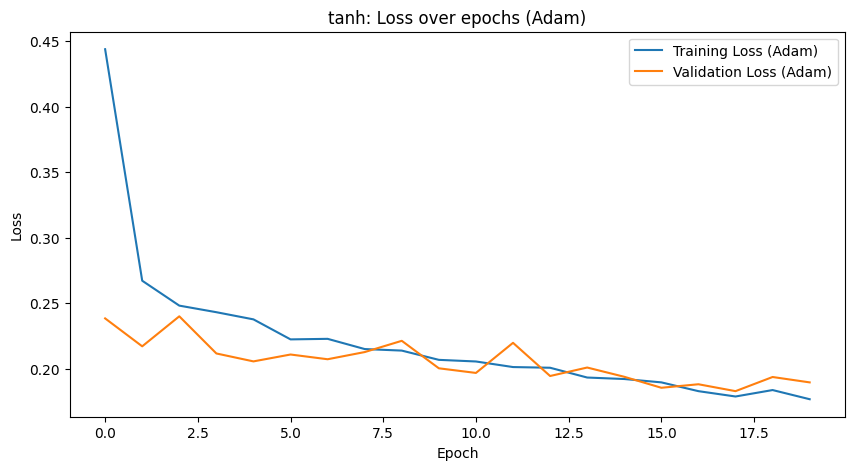

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(history_tanh.history['loss'], label='Training Loss (Adam)')
plt.plot(history_tanh.history['val_loss'], label='Validation Loss (Adam)')
plt.title('tanh: Loss over epochs (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### SGD: Loss Plot

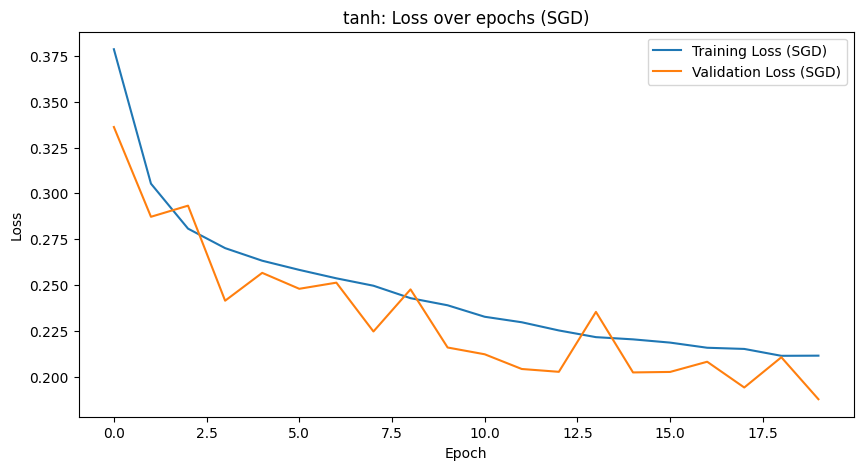

In [37]:
if 'history_tanh_sgd' in globals():
    plt.figure(figsize=(10, 5))
    plt.plot(history_tanh_sgd.history['loss'], label='Training Loss (SGD)')
    plt.plot(history_tanh_sgd.history['val_loss'], label='Validation Loss (SGD)')
    plt.title('tanh: Loss over epochs (SGD)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print('Train tanh SGD cell before plotting')

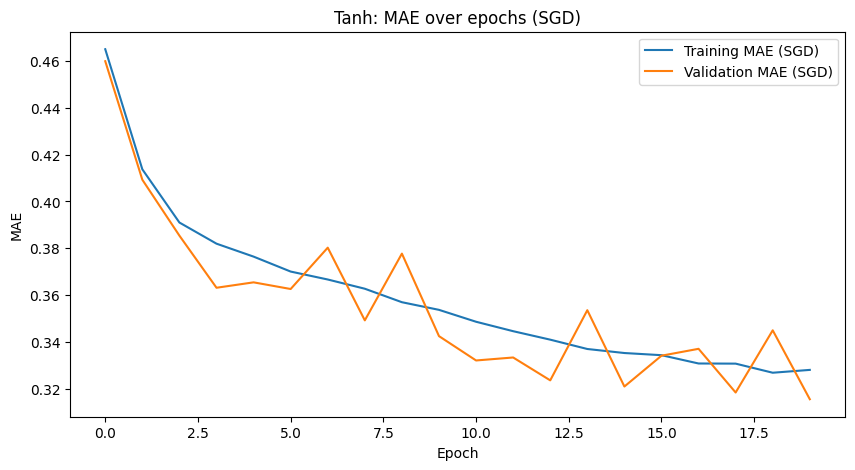

In [38]:
if 'history_tanh_sgd' in globals():
    plt.figure(figsize=(10, 5))
    plt.plot(history_tanh_sgd.history['mae'], label='Training MAE (SGD)')
    plt.plot(history_tanh_sgd.history['val_mae'], label='Validation MAE (SGD)')
    plt.title('Tanh: MAE over epochs (SGD)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
else:
    print('Train tanh SGD cell before plotting')

## Questions to explore

### What changes if I use relu vs tanh activations in hidden layers?

###### ReLU trains faster and scales better (sparse, non-saturating); tanh is smooth and zero‑centered but can saturate and slow/vanish gradients.

### Why should the output layer use a linear activation instead of sigmoid?

###### sigmoid will give values between 0 and 1 and linear give the real value and we want the mean so we use liner here

### Do deeper models (more layers) always improve prediction accuracy?

###### no, the accuracy will be high but thats because of overfitting so the accuracy is meaningless

### How do different metrics (MSE, MAE, RMSE) affect my interpretation of results?

###### MSE: if it hihg then thier is probably outliers
###### MAE: its just the average all error if its high then we did something wrong
###### RMSE: MSE but not squared so it show the actual value